In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import geo
%matplotlib inline

In [271]:
def load_towers():
    import struct
    s = struct.Struct("4x 4s 1s 1s 1s 1s 300s 1296x")
    with open('data/NASR/TWR.txt', 'rb') as f:
        towers = pd.DataFrame([[y.decode().strip() for y in s.unpack_from(x)] for x in f if x.startswith(b"TWR8")])
        towers.columns = ['faa_id', 'bravo', 'charlie', 'delta', 'echo', 'hours']
        towers = towers.sort_values(by='faa_id')
        for cls in ['bravo', 'charlie', 'delta', 'echo']:
            towers[cls] = towers[cls] == 'Y'
    return towers

In [272]:
def dms_to_dec(dms):
    """
    Convert degrees-minutes-seconds to decimal.
    dms_to_dec("41-04-01.0299N") -> 41.066952750000006
    dms_to_dec("073-42-27.2396W")-> -73.70756655555556
    """
    direction = dms[-1]
    deg, minutes, seconds = map(float, dms[:len(dms)-1].split("-"))
    dec = deg + minutes/60 + seconds/3600
    if direction in ('W', 'S'):
        dec = dec * -1
    return dec

# Collect Data

In [273]:
metars = pd.read_pickle('data/metars.pkl')
# Remove coordinates from metar data, will use FAA data instead
metars = metars[[x for x in metars.columns if x not in ('latitude', 'longitude')]]

runways = pd.read_pickle('data/runways.pkl')
towers = load_towers()
conn = sqlite3.connect("data/nasr.db")
airports = pd.read_sql_query("SELECT apt.icao_id as station_id, apt.faa_id as faa_id, apt.latitude_dms, apt.longitude_dms, apt.name, apt.city, apt.state_code, apt.state_name, CAST(AVG(rwy.length) as INT) as mean, COUNT(*) as count, MAX(rwy.length) as max, MIN(rwy.length) as min FROM runways rwy LEFT JOIN airports apt ON rwy.facility_site_number = apt.facility_site_number wHERE apt.facility_type='AIRPORT' AND apt.facility_use='PU' AND rwy.name not like 'H%' AND apt.icao_id IS NOT NULL GROUP BY apt.icao_id  ORDER BY MEAN", conn)

# convert airports latitude and longitude into decimals
for degc, dmsc in [('latitude', 'latitude_dms'), ('longitude', 'longitude_dms')]:
    airports[degc] = airports[dmsc].apply(dms_to_dec)


# Exclude Airports

In [274]:
# Exclude Guam
exclude_airports = ['TNI', 'GUM']
# Exclude Puerto Rico
exclude_airports.extend(['SIG', 'SJU', 'BQN', 'CPX', 'ABO', 'VQS', 'MAZ', 'PSE', 'RVR'])
# Exclude Micronesia, Mariana Islands
exclude_airports.extend(['TTK', 'T11', 'TKK', 'PNI', 'GRO', 'ROR', 'GSN', 'MAJ', ])
# Exclude American Somoa
exclude_airports.extend(['Z08', 'FAQ', 'PPG'])
# Exclude Virgin Islands
exclude_airports.extend(['STT', 'STX', 'TUPJ'])
# Exclude Aruba, Saint Martin, Anguilla
exclude_airports.extend(['TNCE', 'TNCM', 'TFFG', 'TQPF'])
# Exclude Canada, Bermuda 
exclude_airports.extend(['CYSU', 'CYSJ', 'CYSL', 'TXKF'])
# Remove excluded airports
airports = airports[~airports['faa_id'].isin(exclude_airports)]
# Exclude Hawaii, Alaska, and Midway
airports = airports[~airports['state_code'].isin(['HI', 'AK', 'MQ'])]
# Finally, exclude any airport without a state code
airports = airports[~airports['state_code'].isna()]

In [275]:
airports[airports['station_id'].isna()]

,station_id,faa_id,latitude_dms,longitude_dms,name,city,state_code,state_name,mean,count,max,min,latitude,longitude


In [276]:
len(airports)

2127

# Merge Data

In [277]:
data = pd.merge(airports, metars, on='station_id', how='left')
data = pd.merge(data, towers, on='faa_id', how='left')
data = data.fillna(value={'bravo': False, 'charlie': False, 'delta': False, 'echo': False})
data['elevation_ft'] = data['elevation_m'] * 3.281
data['airspace'] = data.apply(lambda x: 'B' if x['bravo'] else 'C' if x['charlie'] else 'D' if x['delta'] else 'E' if x['echo'] else 'G', axis=1)
data = data.set_index(data['station_id'])

In [278]:
nometars = data[data['observation_time'].isna()]
# Exclude data without metar information
data = data[~data['observation_time'].isna()]

In [279]:
nometars.sort_values(by='mean', ascending=False)

,station_id,faa_id,latitude_dms,longitude_dms,name,city,state_code,state_name,mean,count,...,wind_gust_kt,wind_speed_kt,wx_string,bravo,charlie,delta,echo,hours,elevation_ft,airspace
station_id,,,,,,,,,,,,,,,,,,,,,
KTNT,KTNT,TNT,25-51-42.5000N,080-53-49.2000W,DADE-COLLIER TRAINING AND TRANSITION,MIAMI,FL,FLORIDA,10499,1,...,NaN,NaN,NaN,False,False,False,True,"CLASS E SVC 0700-1800 MON-FRI, 0700-1230 SAT-S...",NaN,E
KBXM,KBXM,BXM,43-53-32.4784N,069-56-19.7869W,BRUNSWICK EXECUTIVE,BRUNSWICK,ME,MAINE,8000,2,...,NaN,NaN,NaN,False,False,False,True,,NaN,E
KANK,KANK,ANK,38-32-17.8000N,106-02-55.0000W,HARRIET ALEXANDER FIELD,SALIDA,CO,COLORADO,7351,1,...,NaN,NaN,NaN,False,False,False,False,NaN,NaN,G
KBAM,KBAM,BAM,40-35-56.6000N,116-52-27.6000W,BATTLE MOUNTAIN,BATTLE MOUNTAIN,NV,NEVADA,7299,2,...,NaN,NaN,NaN,False,False,False,True,,NaN,E
KRIF,KRIF,RIF,38-44-02.8000N,112-06-05.7000W,RICHFIELD MUNI,RICHFIELD,UT,UTAH,7100,1,...,NaN,NaN,NaN,False,False,False,False,NaN,NaN,G
KIDL,KIDL,IDL,33-29-08.6000N,090-40-44.0000W,INDIANOLA MUNI,INDIANOLA,MS,MISSISSIPPI,7004,1,...,NaN,NaN,NaN,False,False,False,False,NaN,NaN,G
KDWX,KDWX,DWX,41-02-14.8000N,107-29-33.1000W,DIXON,DIXON,WY,WYOMING,7000,1,...,NaN,NaN,NaN,False,False,False,False,NaN,NaN,G
KMZJ,KMZJ,MZJ,32-30-35.4000N,111-19-31.2000W,PINAL AIRPARK,MARANA,AZ,ARIZONA,6849,1,...,NaN,NaN,NaN,False,False,False,False,NaN,NaN,G
KBPG,KBPG,BPG,32-12-45.4000N,101-31-17.9000W,BIG SPRING MC MAHON-WRINKLE,BIG SPRING,TX,TEXAS,6701,2,...,NaN,NaN,NaN,False,False,False,False,NaN,NaN,G


# Runway Length Distribution

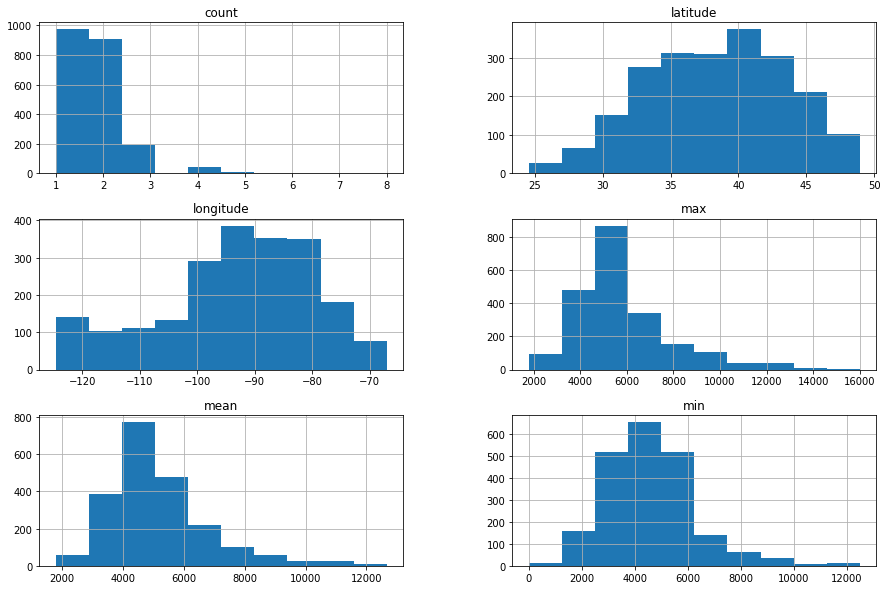

In [280]:
airports.hist(figsize=(15, 10));

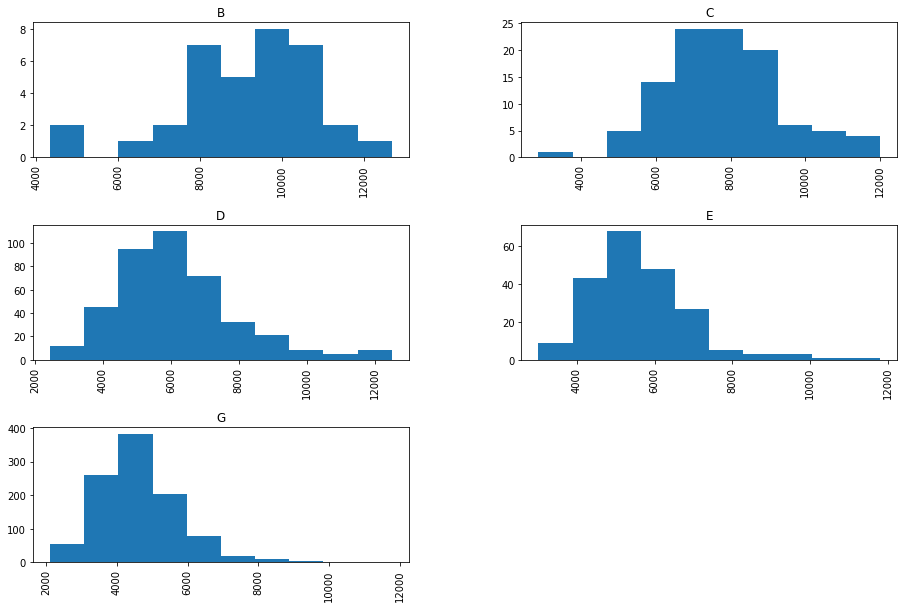

In [281]:
data['mean'].hist(by=data['airspace'], figsize=(15,10));

# Various Charts

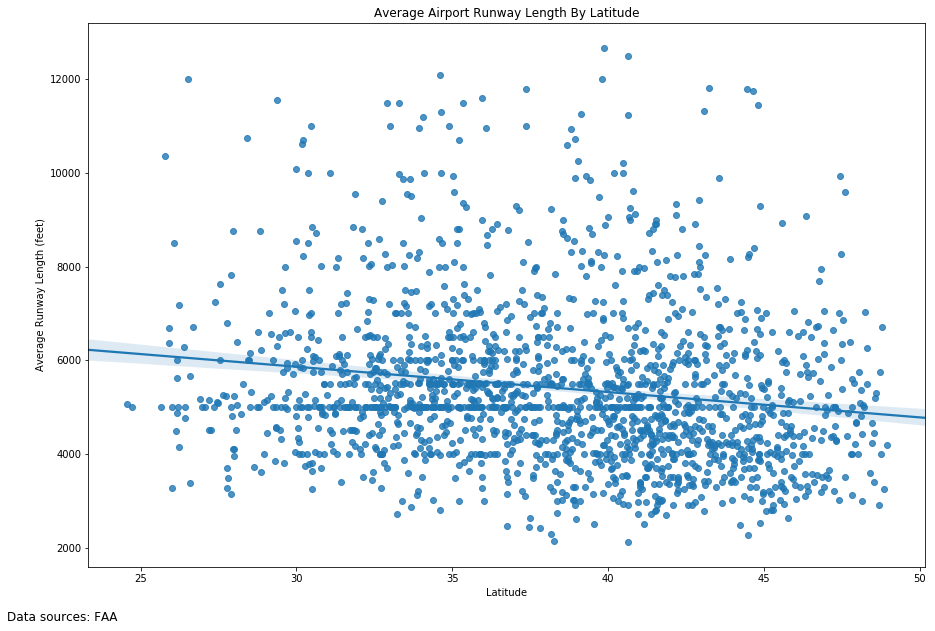

In [282]:
plt.figure(figsize=(15, 10))
axes = sns.regplot(x='latitude', y='mean', data=data)
axes.set_title("Average Airport Runway Length By Latitude")
axes.set_xlabel("Latitude")
axes.set_ylabel("Average Runway Length (feet)")
axes.get_figure().text(0.05, 0.05, "Data sources: FAA", fontsize=12);

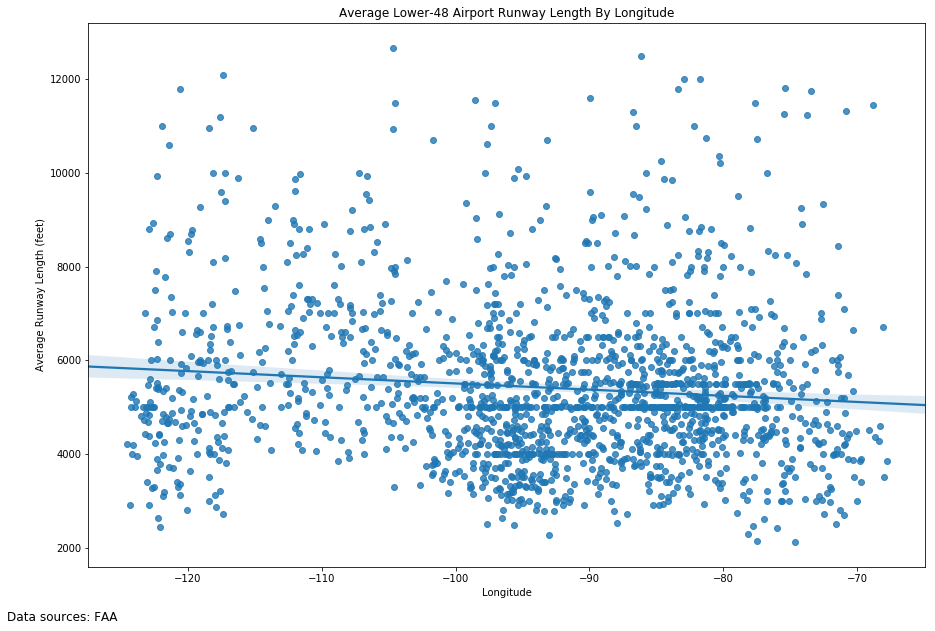

In [283]:
#data.plot.scatter(x='longitude', y='mean', figsize=(15, 10));
plt.figure(figsize=(15, 10))
axes = sns.regplot(x='longitude', y='mean', data=data[(data['longitude'] >= -125) &
                                                      (data['longitude'] <= -65)]);
axes.set_title("Average Lower-48 Airport Runway Length By Longitude")
axes.set_xlabel("Longitude")
axes.set_ylabel("Average Runway Length (feet)")
axes.get_figure().text(0.05, 0.05, "Data sources: FAA", fontsize=12);

In [284]:
def airport_map_plot(data, title="United States (Lower 48) Public Use Airports"):
    plt.figure(figsize=(25, 18))
    axes = sns.scatterplot(x='longitude', y='latitude', data=data, hue='airspace')
    axes.set_title(title, fontsize=20)
    axes.set_xlabel("Longitude")
    axes.set_ylabel("Latitude")
    axes.get_figure().text(0.05, 0.05, "Data sources: FAA", fontsize=12);
    return axes

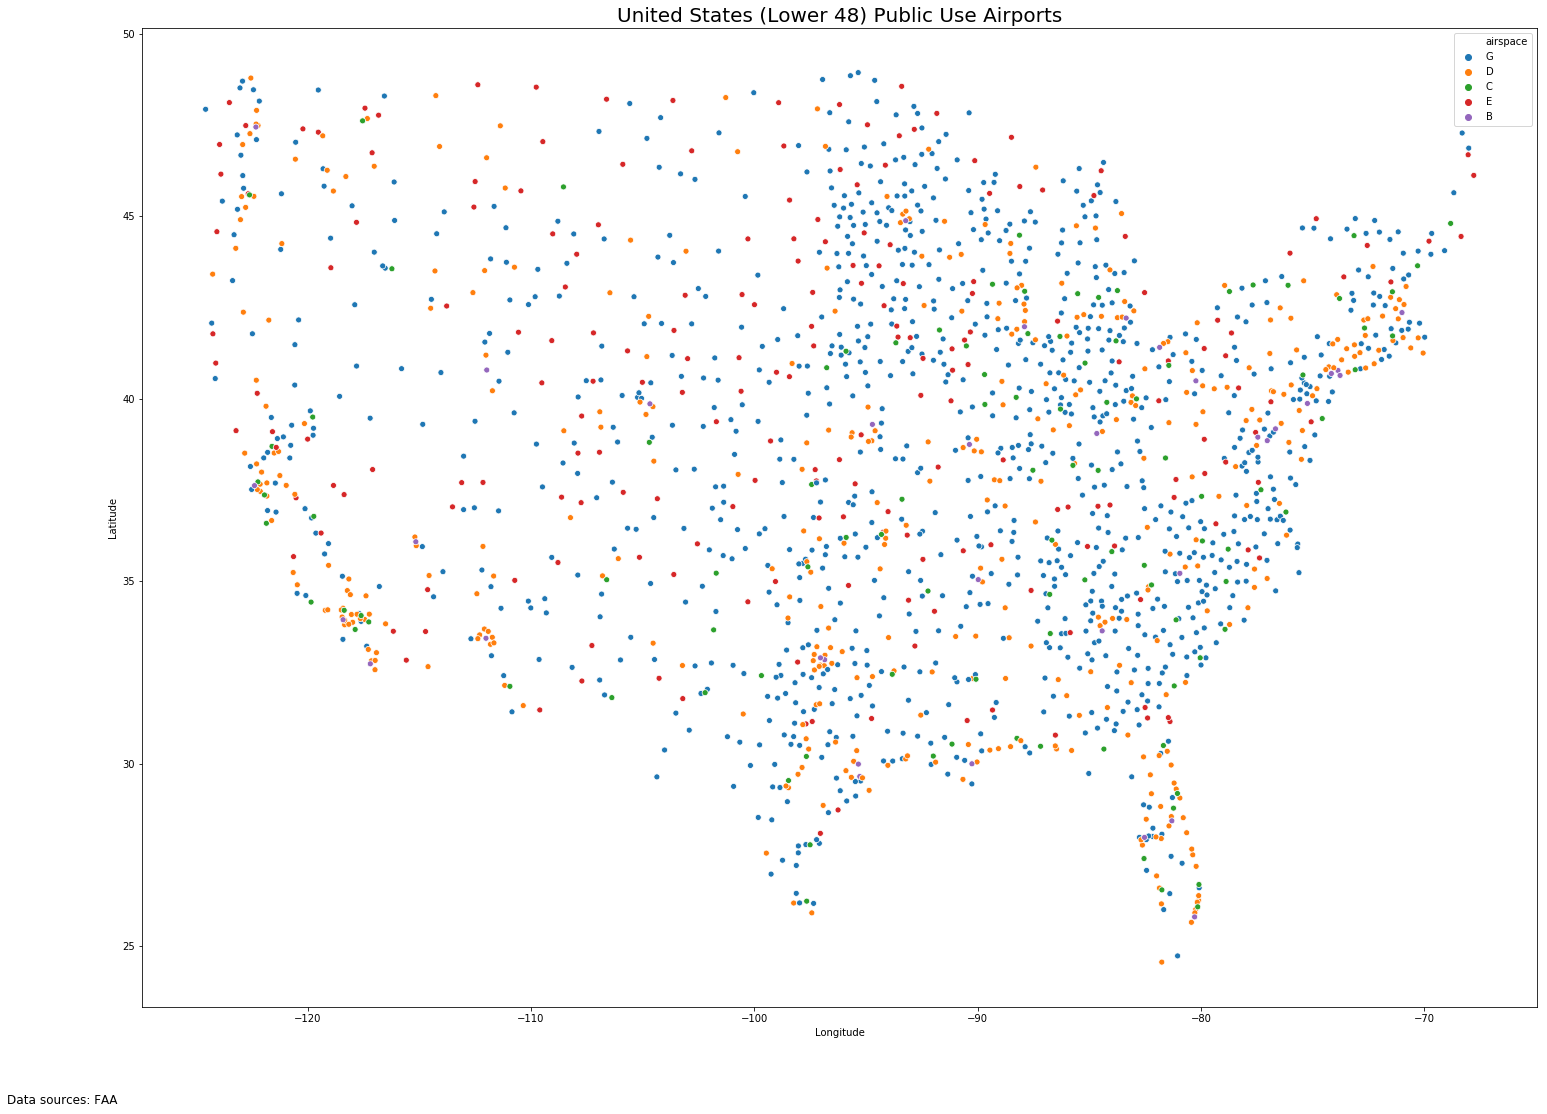

In [285]:
airport_map_plot(data);

# Picking a Subset of Airports

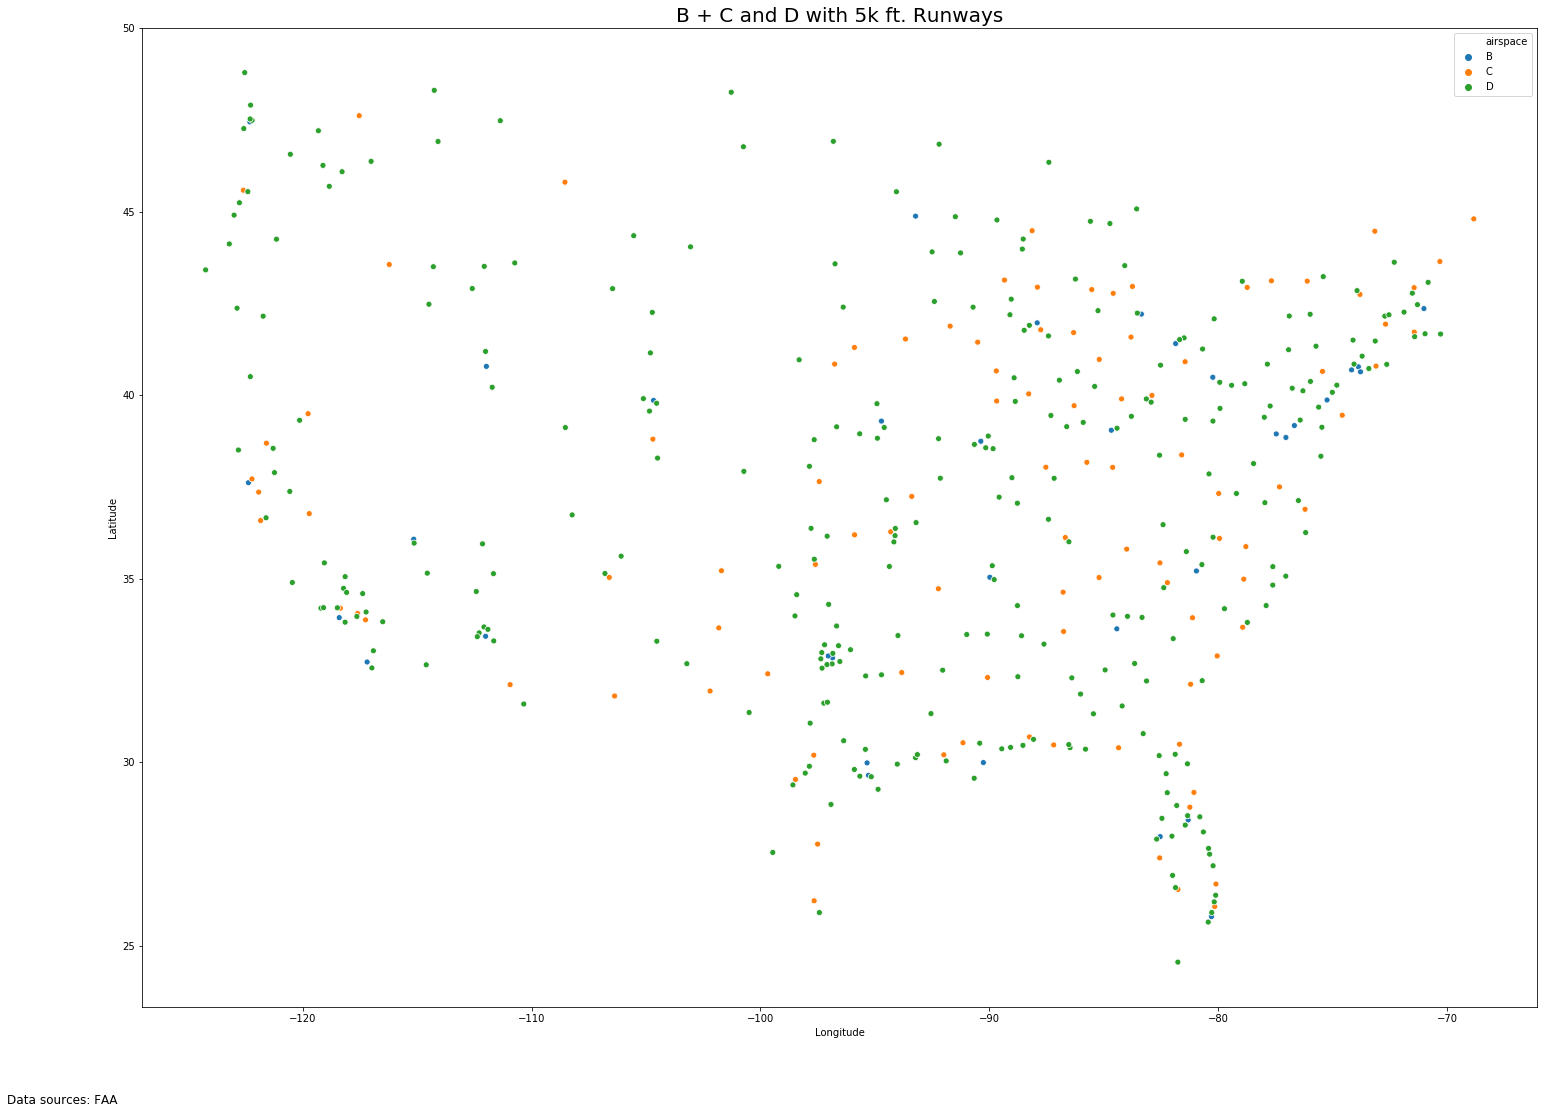

In [286]:
class_b = data[data['airspace'] == 'B']
class_c_long = data[(data['airspace'] == 'C') & (data['mean'] >= 5000)]
class_d_long = data[(data['airspace'] == 'D') & (data['mean'] >= 5000)]
data_subset = pd.concat([class_b, class_c_long, class_d_long])
airport_map_plot(data_subset, title="B + C and D with 5k ft. Runways");

In [287]:
data_subset.sort_values(by='latitude')

,station_id,faa_id,latitude_dms,longitude_dms,name,city,state_code,state_name,mean,count,...,wind_gust_kt,wind_speed_kt,wx_string,bravo,charlie,delta,echo,hours,elevation_ft,airspace
station_id,,,,,,,,,,,,,,,,,,,,,
KEYW,KEYW,EYW,24-33-22.0310N,081-45-35.8410W,KEY WEST INTL,KEY WEST,FL,FLORIDA,5076,1,...,NaN,11.0,None,False,False,True,False,CLASS D SVC 0700-2100; OTHER TIMES CLASS G,16.405,D
KTMB,KTMB,TMB,25-38-51.2294N,080-25-59.6086W,MIAMI EXECUTIVE,MIAMI,FL,FLORIDA,5001,3,...,NaN,7.0,None,False,False,True,True,CLASS D SVC 0700-2300; OTHER TIMES CLASS E,6.562,D
KMIA,KMIA,MIA,25-47-43.3000N,080-17-24.4170W,MIAMI INTL,MIAMI,FL,FLORIDA,10370,4,...,NaN,8.0,None,True,False,False,False,,9.843,B
KBRO,KBRO,BRO,25-54-22.1000N,097-25-33.6000W,BROWNSVILLE/SOUTH PADRE ISLAND INTL,BROWNSVILLE,TX,TEXAS,6699,2,...,NaN,7.0,None,False,False,True,True,CLASS D SVC 0600-0000; OTHER TIMES CLASS E,22.967,D
KOPF,KOPF,OPF,25-54-26.7000N,080-16-41.6000W,MIAMI-OPA LOCKA EXECUTIVE,MIAMI,FL,FLORIDA,6370,3,...,NaN,10.0,None,False,False,True,False,CLASS D SVC 0700-2300; OTHER TIMES CLASS G,52.496,D
KFLL,KFLL,FLL,26-04-18.0000N,080-08-58.9000W,FORT LAUDERDALE/HOLLYWOOD INTL,FORT LAUDERDALE,FL,FLORIDA,8500,2,...,NaN,9.0,None,False,True,False,False,,9.843,C
KFXE,KFXE,FXE,26-11-50.2057N,080-10-14.5426W,FORT LAUDERDALE EXECUTIVE,FORT LAUDERDALE,FL,FLORIDA,5001,2,...,NaN,8.0,None,False,False,True,False,CLASS D SVC CONTINUOUS,19.686,D
KHRL,KHRL,HRL,26-13-37.6000N,097-39-18.5000W,VALLEY INTL,HARLINGEN,TX,TEXAS,7169,3,...,NaN,0.0,None,False,True,False,True,CLASS C SVC 0600-0000 OTHER TIMES CLASS E,32.810,C
KBCT,KBCT,BCT,26-22-42.6000N,080-06-27.7000W,BOCA RATON,BOCA RATON,FL,FLORIDA,6276,1,...,NaN,8.0,None,False,False,True,False,CLASS D SVC 0700-2300; OTHER TIMES CLASS G,13.124,D


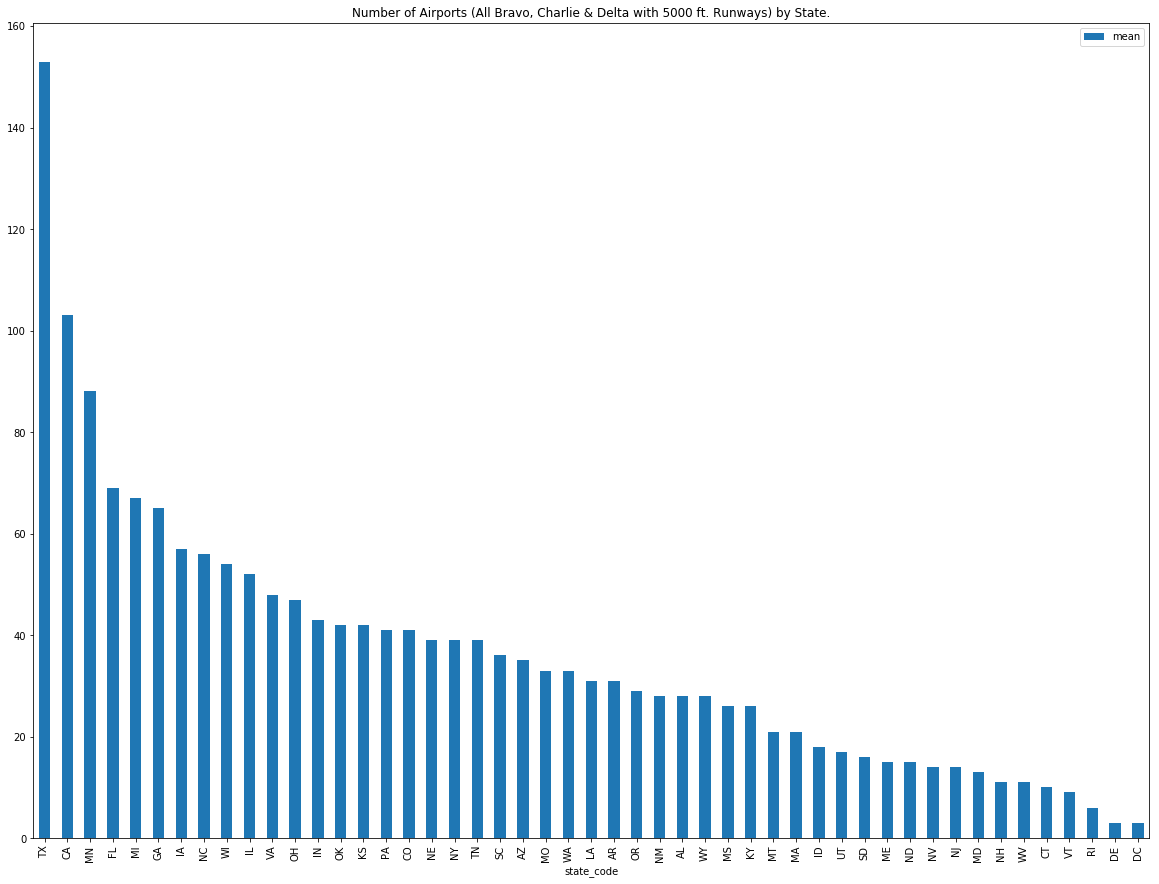

In [288]:
data.groupby('state_code')[['mean']].count().reset_index().sort_values(by='mean', ascending=False).plot.bar(x='state_code', y='mean', figsize=(20,15), title="Number of Airports (All Bravo, Charlie & Delta with 5000 ft. Runways) by State.")

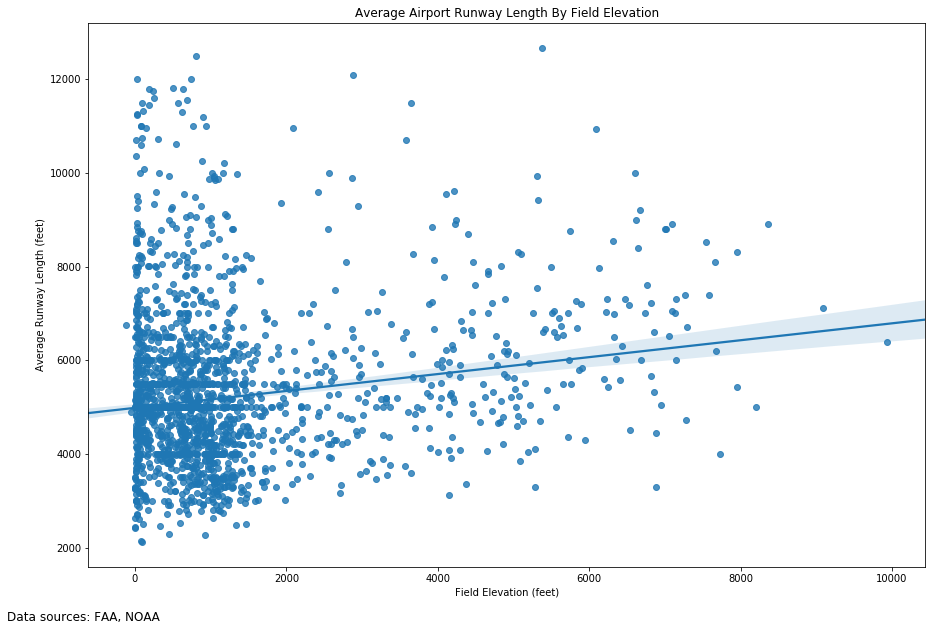

In [217]:
plt.figure(figsize=(15, 10))
axes = sns.regplot(x='elevation_ft', y='mean', data=data, robust=True)
axes.set_title("Average Airport Runway Length By Field Elevation")
axes.set_xlabel("Field Elevation (feet)")
axes.set_ylabel("Average Runway Length (feet)")
axes.get_figure().text(0.05, 0.05, "Data sources: FAA, NOAA", fontsize=12);

# Calculate Distance Between Airports

In [151]:
def distance_between(data, station_a, station_b):
    a = data.loc[station_a]
    b = data.loc[station_b]
    dist = geo.haversine(a['longitude'], a['latitude'], b['longitude'], b['latitude'], miles=True)
    return dist

In [152]:
distance_between(data, 'KLGA', 'KSWF')

51.65440040887829

# Build Graph of Airport Connections

In [15]:
class Vertex:
    def __init__(self, ident):
        self.ident = ident
        self.neighbors = {}
    
    def __str__(self):
        return "{} -> {}".format(self.get_id(), [x.get_id() for x in self.neighbors])
    
    def add_neighbor(self, neighbor, weight=0):
        self.neighbors[neighbor] = weight
    
    def get_connections(self):
        return self.neighbors.keys()
    
    def get_weight(self, neighbor):
        return self.neighbors[neighbor]
    
    def get_id(self):
        return self.ident

In [16]:
class Graph:
    def __init__(self):
        self.vertices = {}
        self.num_vertices = 0

    def __iter__(self):
        return iter(self.vertices.values())

    def add_vertex(self, node):
        self.num_vertices = self.num_vertices + 1
        new_vertex = Vertex(node)
        self.vertices[node] = new_vertex
        return new_vertex

    def get_vertex(self, n):
        if n in self.vertices:
            return self.vertices[n]
        else:
            return None

    def add_edge(self, frm, to, cost = 0):
        if frm not in self.vertices:
            self.add_vertex(frm)
        if to not in self.vertices:
            self.add_vertex(to)

        self.vertices[frm].add_neighbor(self.vertices[to], cost)
        self.vertices[to].add_neighbor(self.vertices[frm], cost)

    def get_vertices(self):
        return self.vertices.keys()

In [19]:
G = Graph()
G.add_vertex('A')
G.add_vertex('B')
G.add_edge('A', 'B')

In [21]:
str(G.get_vertex('A'))

"A -> ['B']"

# Build Airport Graph

In [22]:
airport_graph = Graph()

In [43]:
distance_matrix = [[distance_between(data, x, y) for y in data['station_id']] for x in data['station_id']]

In [44]:
distances = pd.DataFrame(distance_matrix, columns=data['station_id'], index=data['station_id'])

In [46]:
distance_between(data, 'PAWR', 'PAOC')

nan

In [47]:
data.loc['PAWR']

station_id                PAWR
faa_id                     IEM
mean                      1480
count                        1
max                       1480
min                       1480
observation_time           NaT
altim_in_hg                NaN
cloud_base_ft_agl          NaN
dewpoint_c                 NaN
elevation_m                NaN
flight_category            NaN
latitude                   NaN
longitude                  NaN
maxT24hr_c                 NaN
maxT_c                     NaN
metar_type                 NaN
minT24hr_c                 NaN
minT_c                     NaN
pcp3hr_in                  NaN
pcp6hr_in                  NaN
precip_in                  NaN
quality_control_flags      NaN
raw_text                   NaN
sea_level_pressure_mb      NaN
sky_cover                  NaN
snow_in                    NaN
temp_c                     NaN
vert_vis_ft                NaN
visibility_statute_mi      NaN
wind_dir_degrees           NaN
wind_gust_kt               NaN
wind_spe

In [52]:
metars[metars['station_id'] == 'KHPN'][['latitude', 'longitude']]

,latitude,longitude
3,41.07,-73.7
